In [8]:
# %%capture
# !pip install alibi

In [11]:
# %%capture
# !pip install alibi-detect

In [65]:
import pandas as pd
import numpy as np 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import scipy.stats as stats
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 

import alibi 
from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.saving import save_detector, load_detector

import warnings
warnings.filterwarnings('ignore')

In [66]:
# Loading a sample dataset
data_raw = pd.read_csv('Loan_Data.csv')
data_raw = data_raw.drop(['Credit_History','Loan_ID'],axis=1) # dropping this feature because it is high importance and this will hide us from detecting drift in other variables
print(data_raw.shape)
data_raw.head()

(614, 11)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Urban,Y


In [67]:
data_raw.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Property_Area         0
Loan_Status           0
dtype: int64

In [68]:
data_raw = data_raw.dropna()

In [69]:
data_raw.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Property_Area        0
Loan_Status          0
dtype: int64

In [70]:
from sklearn.model_selection import train_test_split

X_raw = data_raw.drop('Loan_Status',axis=1)
Y_raw = data_raw[['Loan_Status']]

x_train, x_test, y_train, y_test = train_test_split(X_raw,Y_raw,stratify=Y_raw,test_size=0.3)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(366, 10) (366, 1)
(157, 10) (157, 1)


In [71]:
# Create the dictionary mapping for categorical features to numbers for the DataDrift library to work
cat_features = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']

temp = x_train.copy()

for cat_var in cat_features:
    fileName = cat_var+"_mapping.pkl"
    temp[cat_var] = temp[cat_var].astype('category')
    obj = dict(zip(temp[cat_var],temp[cat_var].cat.codes))
    print(obj)
    with open(fileName,'wb') as f:
        pickle.dump(obj,f)

{'Male': 1, 'Female': 0}
{'Yes': 1, 'No': 0}
{'3+': 3, '1': 1, '0': 0, '2': 2}
{'Graduate': 0, 'Not Graduate': 1}
{'No': 0, 'Yes': 1}
{'Urban': 2, 'Semiurban': 1, 'Rural': 0}


In [72]:
# Encode the categorical features to numbers for the DataDrift library to work
cat_features = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']

for cat_var in cat_features:
    fileName = cat_var+"_mapping.pkl"
    with open(fileName,'rb') as f:
        obj = pickle.load(f)

    x_train[cat_var] = x_train[cat_var].map(obj)

In [73]:
print(x_train.shape)
x_train.head()

(366, 10)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area
257,1,1,3,0,0,5250,0.0,94.0,360.0,2
299,1,1,1,0,0,2014,2925.0,113.0,360.0,2
283,0,0,0,0,0,1811,1666.0,54.0,360.0,2
451,1,1,2,1,0,1958,1456.0,60.0,300.0,2
192,1,1,0,1,0,6033,0.0,160.0,360.0,2


In [74]:
print(y_train.shape)
y_train.head()

(366, 1)


,Loan_Status
257,N
299,N
283,Y
451,Y
192,N


In [76]:
# Splitting the data to a REFERENCE_SET and two TEST_SETs
n_ref = 200
n_test = 60

X = x_train.copy()
Y = y_train.copy()

X_ref, X_t0, X_t1 = X.iloc[:n_ref], X.iloc[n_ref:n_ref + n_test], X.iloc[n_ref + n_test:n_ref + 2 * n_test]
X_ref.shape, X_t0.shape, X_t1.shape

((200, 10), (60, 10), (60, 10))

##### Detect Data Drift:

We need to provide the drift detector with the columns which contain categorical features so it knows which features require the Chi-Squared and which ones require the K-S univariate test. We can either provide a dict with as keys the column indices and as values the number of possible categories or just set the values to None and let the detector infer the number of categories from the reference data as in the example below:

In [77]:
X_ref.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area
257,1,1,3,0,0,5250,0.0,94.0,360.0,2
299,1,1,1,0,0,2014,2925.0,113.0,360.0,2
283,0,0,0,0,0,1811,1666.0,54.0,360.0,2
451,1,1,2,1,0,1958,1456.0,60.0,300.0,2
192,1,1,0,1,0,6033,0.0,160.0,360.0,2


In [78]:
categories_per_feature = {f: None for f in [0,1,2,3,4,9]}
categories_per_feature

{0: None, 1: None, 2: None, 3: None, 4: None, 9: None}

In [79]:
# Initialize the detector
cd = TabularDrift(X_ref.values, p_val=.05, categories_per_feature=categories_per_feature)

In [15]:
# # We can also save/load an initialised detector: (not working; throwing some error)
# filepath = 'TrainedTabularDriftObj'  # change to directory where detector is saved
# save_detector(cd, filepath)
# trained_drift_model = load_detector(filepath,allow_pickle=True)

In [80]:
# Using pickle to save and load it the trained detector
with open('Trained_Drift_Detector.pkl','wb') as F:
    pickle.dump(cd,F)

with open('Trained_Drift_Detector.pkl','rb') as F:
    trained_drift_model = pickle.load(F)    

**Predicting on the Test data:**

In [81]:
preds = trained_drift_model.predict(X_t0.values)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


In [82]:
preds

{'data': {'is_drift': 0,
  'distance': array([0.03385417, 0.2980364 , 0.71121275, 0.09782918, 0.3766561 ,
         0.18833333, 0.17333333, 0.205     , 0.045     , 0.41977727],
        dtype=float32),
  'p_val': array([0.8540174 , 0.585116  , 0.8705635 , 0.75445044, 0.5393983 ,
         0.06674672, 0.11162439, 0.03582517, 0.9999323 , 0.8106745 ],
        dtype=float32),
  'threshold': 0.005},
 'meta': {'name': 'TabularDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.0',
  'detector_type': 'drift'}}

In [83]:
cat_features = ['Gender','Married','Education','Self_Employed','Property_Area']

for f in range(trained_drift_model.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    # print(f, stat)
    fname = X_ref.columns.tolist()[f]
    # print(f, fname)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Gender -- Chi2 0.034 -- p-value 0.854
Married -- Chi2 0.298 -- p-value 0.585
Dependents -- Chi2 0.711 -- p-value 0.871
Education -- Chi2 0.098 -- p-value 0.754
Self_Employed -- Chi2 0.377 -- p-value 0.539
ApplicantIncome -- K-S 0.188 -- p-value 0.067
CoapplicantIncome -- K-S 0.173 -- p-value 0.112
LoanAmount -- K-S 0.205 -- p-value 0.036
Loan_Amount_Term -- K-S 0.045 -- p-value 1.000
Property_Area -- Chi2 0.420 -- p-value 0.811


Testing whether changing few values in one of the column have any impact or not for the same dataset

In [84]:
test = X_t0.copy()
test.iloc[:20,0] = 5
print(test.shape)
test.head()

(60, 10)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area
5,5,1,2,0,1,5417,4196.0,267.0,360.0,2
554,5,1,0,0,0,3593,4266.0,132.0,180.0,0
156,5,1,1,0,0,6000,0.0,160.0,360.0,0
324,5,1,3,0,0,15000,0.0,300.0,360.0,0
130,5,0,0,0,1,20166,0.0,650.0,480.0,2


In [85]:
preds = trained_drift_model.predict(test.values)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? Yes!


In [86]:
preds

{'data': {'is_drift': 1,
  'distance': array([7.2368927e+01, 2.9803640e-01, 7.1121275e-01, 9.7829178e-02,
         3.7665609e-01, 1.8833333e-01, 1.7333333e-01, 2.0500000e-01,
         4.5000002e-02, 4.1977727e-01], dtype=float32),
  'p_val': array([1.9288032e-16, 5.8511603e-01, 8.7056351e-01, 7.5445044e-01,
         5.3939831e-01, 6.6746719e-02, 1.1162439e-01, 3.5825167e-02,
         9.9993229e-01, 8.1067449e-01], dtype=float32),
  'threshold': 0.005},
 'meta': {'name': 'TabularDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.0',
  'detector_type': 'drift'}}

In [87]:
for f in range(trained_drift_model.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    # print(f, stat)
    fname = X_ref.columns.tolist()[f]
    # print(f, fname)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Gender -- Chi2 72.369 -- p-value 0.000
Married -- Chi2 0.298 -- p-value 0.585
Dependents -- Chi2 0.711 -- p-value 0.871
Education -- Chi2 0.098 -- p-value 0.754
Self_Employed -- Chi2 0.377 -- p-value 0.539
ApplicantIncome -- K-S 0.188 -- p-value 0.067
CoapplicantIncome -- K-S 0.173 -- p-value 0.112
LoanAmount -- K-S 0.205 -- p-value 0.036
Loan_Amount_Term -- K-S 0.045 -- p-value 1.000
Property_Area -- Chi2 0.420 -- p-value 0.811


The above method will give us an indicator for the whole dataset and drift will be 1 or 0 based on all the features in the dataset.

Follow the code below to get drift indicator for each features:

The only difference between the above and the below is that 'is_drift' key in the below has drift indicator for each feature whereas in the above it will be a single 1/0 for the whole dataset.

In [88]:
# If you are interested in individual feature-wise drift, this is also possible:
fpreds = trained_drift_model.predict(test.values, drift_type='feature')
fpreds

{'data': {'is_drift': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
  'distance': array([7.2368927e+01, 2.9803640e-01, 7.1121275e-01, 9.7829178e-02,
         3.7665609e-01, 1.8833333e-01, 1.7333333e-01, 2.0500000e-01,
         4.5000002e-02, 4.1977727e-01], dtype=float32),
  'p_val': array([1.9288032e-16, 5.8511603e-01, 8.7056351e-01, 7.5445044e-01,
         5.3939831e-01, 6.6746719e-02, 1.1162439e-01, 3.5825167e-02,
         9.9993229e-01, 8.1067449e-01], dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'TabularDrift',
  'online': False,
  'data_type': None,
  'version': '0.11.0',
  'detector_type': 'drift'}}

In [89]:
for f in range(trained_drift_model.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    # print(f, stat)
    fname = X_ref.columns.tolist()[f]
    # print(f, fname)
    is_drift = fpreds['data']['is_drift'][f]
    stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Gender -- Drift? Yes! -- Chi2 72.369 -- p-value 0.000
Married -- Drift? No! -- Chi2 0.298 -- p-value 0.585
Dependents -- Drift? No! -- Chi2 0.711 -- p-value 0.871
Education -- Drift? No! -- Chi2 0.098 -- p-value 0.754
Self_Employed -- Drift? No! -- Chi2 0.377 -- p-value 0.539
ApplicantIncome -- Drift? No! -- K-S 0.188 -- p-value 0.067
CoapplicantIncome -- Drift? No! -- K-S 0.173 -- p-value 0.112
LoanAmount -- Drift? Yes! -- K-S 0.205 -- p-value 0.036
Loan_Amount_Term -- Drift? No! -- K-S 0.045 -- p-value 1.000
Property_Area -- Drift? No! -- Chi2 0.420 -- p-value 0.811


##### Detect Model Drift:

In [136]:
# Evidently can be used to check the model drift
# You can calculate the performance metrics for the model and pickle it. Then at the time of monitoring check for how much deviation the scoring data is from the actual obsered metrics. if the deviation is more than +-10% (or any threshold) then flag it as model drift and proceed for retraining (same process used in evidently library)

In [90]:
x_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area
257,1,1,3,0,0,5250,0.0,94.0,360.0,2
299,1,1,1,0,0,2014,2925.0,113.0,360.0,2
283,0,0,0,0,0,1811,1666.0,54.0,360.0,2
451,1,1,2,1,0,1958,1456.0,60.0,300.0,2
192,1,1,0,1,0,6033,0.0,160.0,360.0,2


In [91]:
# Train a model on the training data and save the model metrics & the model
# Then use the categorical mapping file to prepare the test data and score it using the trained model
# compare the train and test performance (also their deviation)
# Then change the test data a bit and then do the above two steps again.
# wrap the above steps as a function that will return model drift or not based on train and test performance deviation

In [92]:
# RF
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

rf = RandomForestClassifier(max_depth=8, min_samples_split=10)
rf.fit(x_train,y_train)
rf.score(x_train,y_train)

0.7923497267759563

              precision    recall  f1-score   support

           N       0.97      0.31      0.47       109
           Y       0.77      1.00      0.87       257

    accuracy                           0.79       366
   macro avg       0.87      0.65      0.67       366
weighted avg       0.83      0.79      0.75       366



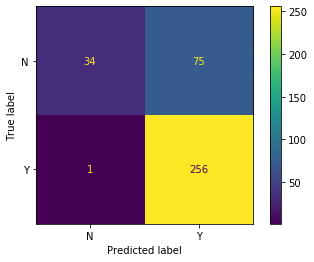

In [93]:
y_train_encode = [1 if i == 'Y' else 0 for i in y_train.values]
y_pred = rf.predict_proba(x_train)[:,1]
y_pred_class = rf.predict(x_train)
y_pred_class_encode = [1 if i == 'Y' else 0 for i in y_pred_class]
print(metrics.classification_report(y_train,y_pred_class))
metrics.plot_confusion_matrix(rf,x_train,y_train)


In [94]:
# logging the training performance metrics and the trained model
precision = metrics.precision_score(y_train_encode,y_pred_class_encode)
recall = metrics.recall_score(y_train_encode,y_pred_class_encode)
roc_auc = metrics.roc_auc_score(y_train_encode,y_pred)

training_performance_metrics = dict()
training_performance_metrics['Precision'] = np.round(precision,2)
training_performance_metrics['Recall'] = np.round(recall,2)
training_performance_metrics['Roc-Auc'] = np.round(roc_auc,2)

print(training_performance_metrics)

with open('Training_Perfrom_Metrics.pkl','wb') as F:
    pickle.dump(training_performance_metrics,F)

with open('RF_Loan_Model.pkl','wb') as F:
    pickle.dump(rf,F)


{'Precision': 0.77, 'Recall': 1.0, 'Roc-Auc': 0.96}


In [95]:
# Function to check model drift
def check_model_drift(ref_metric_dict,cur_metric_dict,type='classification',tol=0.1):
    if type == 'classification':
        precision_change = abs((cur_metric_dict['Precision']-ref_metric_dict['Precision'])/ref_metric_dict['Precision'])
        recall_change = abs((cur_metric_dict['Recall']-ref_metric_dict['Recall'])/ref_metric_dict['Recall'])
        roc_auc_change = abs((cur_metric_dict['Roc-Auc']-ref_metric_dict['Roc-Auc'])/ref_metric_dict['Roc-Auc'])

        counter = 0
        for i in [precision_change,recall_change,roc_auc_change]:
            if i > 0.1:
                counter += 1

        if counter > 0:
            print("ALERT! There is a model drift.")
            print("Change in Precision: "+ str(np.round(100*precision_change,2))+"%")
            print("Change in Recall: "+ str(np.round(100*recall_change,2))+"%")
            print("Change in Roc-Auc: "+ str(np.round(100*roc_auc_change,2))+"%")
            return 1
        else:
            print("There is no model drift.")
            return 0

    else:
        pass 

In [98]:
test = training_performance_metrics.copy()
test['Precision'] = 0.69
test

{'Precision': 0.69, 'Recall': 1.0, 'Roc-Auc': 0.96}

In [99]:
check_model_drift(training_performance_metrics,test)

ALERT! There is a model drift.
Change in Precision: 10.39%
Change in Recall: 0.0%
Change in Roc-Auc: 0.0%


1

Applying the preprocessing and preparing the test data for scoring and model drift checking

In [100]:
print(x_test.shape)
x_test.head()

(157, 10)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area
483,Male,Yes,0,Graduate,No,10833,0.0,234.0,360.0,Semiurban
518,Male,No,0,Graduate,No,4683,1915.0,185.0,360.0,Semiurban
452,Male,Yes,0,Graduate,No,3948,1733.0,149.0,360.0,Rural
442,Male,No,3+,Not Graduate,No,4707,1993.0,148.0,360.0,Semiurban
87,Male,Yes,0,Graduate,No,2500,2118.0,104.0,360.0,Semiurban


In [101]:
x_test_with_noise = x_test.copy()

In [102]:
# Adding noise to the data
x_test_with_noise.iloc[100:110,0] = 'None'
x_test_with_noise.iloc[120:130,0] = 'None'

x_test_with_noise.iloc[100:110,7] = 1500
x_test_with_noise.iloc[120:130,7] = 1600

x_test_with_noise.iloc[90:110,6] = 7000
x_test_with_noise.iloc[120:130,6] = 7000

In [103]:
x_test_with_noise.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area
483,Male,Yes,0,Graduate,No,10833,0.0,234.0,360.0,Semiurban
518,Male,No,0,Graduate,No,4683,1915.0,185.0,360.0,Semiurban
452,Male,Yes,0,Graduate,No,3948,1733.0,149.0,360.0,Rural
442,Male,No,3+,Not Graduate,No,4707,1993.0,148.0,360.0,Semiurban
87,Male,Yes,0,Graduate,No,2500,2118.0,104.0,360.0,Semiurban


In [104]:
def prepare_data(x_t):
    x_t = x_t.dropna()
    cat_features = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']

    for cat_var in cat_features:
        fileName = cat_var+"_mapping.pkl"
        with open(fileName,'rb') as f:
            obj = pickle.load(f)

        # Checking if any new categories in the columns and encoding them with -99
        ref_cats = list(obj.keys())
        cur_cats = x_t[cat_var].unique().tolist()

        unseen_cats = list(set(cur_cats).difference(set(ref_cats)))
        for cat in unseen_cats:
            if cat not in obj.keys():
                obj[cat] = -99
        x_t[cat_var] = x_t[cat_var].map(obj)
    
    return x_t 

In [105]:
# temp = x_test.copy()
temp = x_test_with_noise.copy()
x_test_prepared = prepare_data(temp)
print(x_test_prepared.shape)
x_test_prepared.head()

(157, 10)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area
483,1,1,0,0,0,10833,0.0,234.0,360.0,1
518,1,0,0,0,0,4683,1915.0,185.0,360.0,1
452,1,1,0,0,0,3948,1733.0,149.0,360.0,0
442,1,0,3,1,0,4707,1993.0,148.0,360.0,1
87,1,1,0,0,0,2500,2118.0,104.0,360.0,1


In [106]:
x_test_prepared.Gender.value_counts()

 1     115
 0      22
-99     20
Name: Gender, dtype: int64

50
(51, 1)
(51,)
              precision    recall  f1-score   support

           N       1.00      0.12      0.21        17
           Y       0.69      1.00      0.82        34

    accuracy                           0.71        51
   macro avg       0.85      0.56      0.51        51
weighted avg       0.80      0.71      0.62        51

ALERT! There is a model drift.
Change in Precision: 9.89%
Change in Recall: 0.0%
Change in Roc-Auc: 30.07%
100
(101, 1)
(101,)
              precision    recall  f1-score   support

           N       0.80      0.12      0.21        33
           Y       0.70      0.99      0.82        68

    accuracy                           0.70       101
   macro avg       0.75      0.55      0.51       101
weighted avg       0.73      0.70      0.62       101

ALERT! There is a model drift.
Change in Precision: 9.36%
Change in Recall: 1.47%
Change in Roc-Auc: 35.24%
150
(151, 1)
(151,)
              precision    recall  f1-score   support

           N       

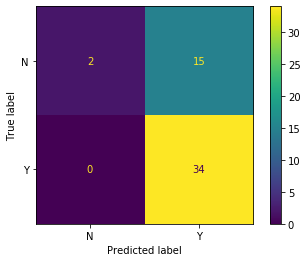

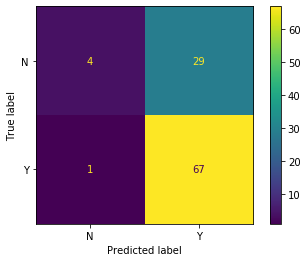

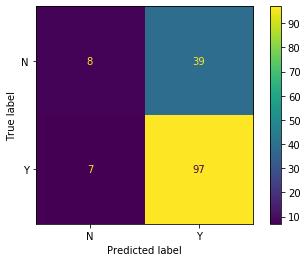

In [108]:
# Create a simulation that predicts every row and after 50 rows gets the performance metrics for the same and compare it with reference metrics for model drift
x_test_raw = x_test_prepared.copy()
y_test_raw = y_test.copy()

for i in range(x_test_prepared.shape[0]): # x_test_prepared.shape[0]
    temp = x_test_prepared.iloc[i:i+1]    
    
    # loading the trained model
    with open('RF_Loan_Model.pkl','rb') as F:
        model = pickle.load(F)
    
    # Loading the Training performance metrics
    with open('Training_Perfrom_Metrics.pkl', 'rb') as F:
        train_performance_metrics = pickle.load(F)
    
    # Getting predictions on the test data
    temp['prediction_prob'] = model.predict_proba(x_test_prepared.iloc[i:i+1])[:,1]
    temp['prediction_class'] = model.predict(x_test_prepared.iloc[i:i+1])
    # display(temp)

    # Concatenating the dataframe
    if i == 0:
        df_log = temp.copy()
    else:
        df_log = pd.concat([df_log,temp],axis=0)

    # After every 50 predictions get the performance metrics and check for model drift
    if i % 50 == 0 and i != 0:
        print(i)
        y_temp = y_test.iloc[:i+1,:]
        y_test_encode = [1 if i == 'Y' else 0 for i in y_temp.values]
        y_pred = df_log['prediction_prob'].values
        y_pred_class = df_log['prediction_class'].values
        y_pred_class_encode = [1 if i == 'Y' else 0 for i in y_pred_class]
        print(y_temp.shape)
        print(y_pred_class.shape)
        print(metrics.classification_report(y_temp,y_pred_class))
        metrics.plot_confusion_matrix(rf,x_test_prepared.iloc[:i+1,:],y_temp)

        precision = metrics.precision_score(y_test_encode,y_pred_class_encode)
        recall = metrics.recall_score(y_test_encode,y_pred_class_encode)
        roc_auc = metrics.roc_auc_score(y_test_encode,y_pred)

        ref_perform_metric = dict()
        ref_perform_metric['Precision'] = precision
        ref_perform_metric['Recall'] = recall
        ref_perform_metric['Roc-Auc'] = roc_auc

        check_model_drift(train_performance_metrics,ref_perform_metric)


In [62]:
print(df_log.shape)
df_log.head()

(157, 12)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,prediction_prob,prediction_class
247,1,1,1,1,0,6608,0.0,137.0,180.0,2,0.705287,Y
83,1,1,0,0,0,6000,2250.0,265.0,360.0,1,0.842968,Y
22,1,1,0,1,0,2600,1911.0,116.0,360.0,1,0.894557,Y
444,1,1,0,0,0,7333,8333.0,175.0,300.0,0,0.541696,Y
499,1,0,0,0,0,6283,4416.0,209.0,360.0,0,0.617272,Y
